In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_DO(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=5, filters=64, strides=1, padding='same', 
                      input_shape=input_shape)) 
    model.add(Activation('tanh'))
#     model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=5, filters=64*(2**int((i+1)/4)), strides=1, 
                          padding='same'))
        model.add(Activation('tanh'))
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(Dropout(0.25))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 10):
    model = build_1d_cnn_custom_DO(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 64)         384       
_________________________________________________________________
activation (Activation)      (None, 16000, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1024000)           0         
_________________________________________________________________
dropout (Dropout)            (None, 1024000)           0         
_________________________________________________________________
dense (Dense)                (None, 16)                16384016  
Total params: 16,384,400
Trainable params: 16,384,400
Non-trainable params: 0
_________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
activation_15 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
activation_16 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 5333, 64)          20544     
_________________________________________________________________
activation_17 (Activation)   (None, 5333, 64)          0         
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_36 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
activation_36 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
activation_37 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_28 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_38 (Conv1D)           (None, 5333, 64)          20544     
_________________________________________________________________
activation_38 (Activation)   (None, 5333, 64)          0         
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36736/36805 [============================>.] - ETA: 0s - loss: 2.7422 - acc: 0.1095
Epoch 00001: val_loss improved from inf to 2.73753, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_025_DO_1_conv_checkpoint/001-2.7375.hdf5
36805/36805 [==============================] - 29s 787us/sample - loss: 2.7420 - acc: 0.1096 - val_loss: 2.7375 - val_acc: 0.1046
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4746 - acc: 0.2691
Epoch 00002: val_loss did not improve from 2.73753
36805/36805 [==============================] - 27s 727us/sample - loss: 2.4746 - acc: 0.2691 - val_loss: 2.8316 - val_acc: 0.1085
Epoch 3/500
36736/36805 [============================>.] - ETA: 0s - loss: 2.2111 - acc: 0.3570
Epoch 00003: val_loss did not improve from 2.73753
36805/36805 [==============================] - 27s 727us/sample - loss: 2.2110 - acc: 0.3571 - val_loss: 

36800/36805 [============================>.] - ETA: 0s - loss: 0.5339 - acc: 0.8650
Epoch 00029: val_loss did not improve from 2.73753
36805/36805 [==============================] - 27s 720us/sample - loss: 0.5339 - acc: 0.8650 - val_loss: 7.2360 - val_acc: 0.1039
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5107 - acc: 0.8713
Epoch 00030: val_loss did not improve from 2.73753
36805/36805 [==============================] - 27s 720us/sample - loss: 0.5106 - acc: 0.8713 - val_loss: 7.3564 - val_acc: 0.1016
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4898 - acc: 0.8774
Epoch 00031: val_loss did not improve from 2.73753
36805/36805 [==============================] - 27s 723us/sample - loss: 0.4898 - acc: 0.8774 - val_loss: 7.4695 - val_acc: 0.1020
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4720 - acc: 0.8834
Epoch 00032: val_loss did not improve from 2.73753
36805/36805 [==================

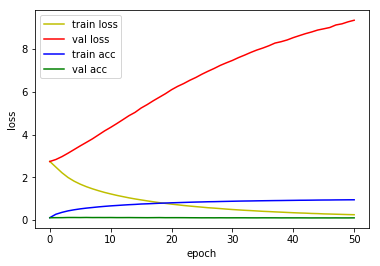

4815/4815 [==============================] - 1s 302us/sample - loss: 2.7266 - acc: 0.1051
Loss: 2.7266184161137694 Accuracy: 0.105088264

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3320 - acc: 0.2661
Epoch 00001: val_loss improved from inf to 2.12189, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_025_DO_2_conv_checkpoint/001-2.1219.hdf5
36805/36805 [==============================] - 42s 1ms/sample - loss: 2.3320 - acc: 0.2661 - val_loss: 2.1219 - val_acc: 0.3433
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8159 - acc: 0.4377
Epoch 00002: val_loss improved from 2.12189 to 2.04540, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_025_DO_2_conv_checkpoint/002-2.0454.hdf5
36805/36805 [==============================] - 41s 1ms/sample - loss: 1.8157 - acc: 0.4378 - val_loss: 2.0454 - val_acc: 0.3580
Epoch 3/500
36800/36805 [============================>.] - ETA: 0

36800/36805 [============================>.] - ETA: 0s - loss: 0.0791 - acc: 0.9849
Epoch 00029: val_loss did not improve from 2.04540
36805/36805 [==============================] - 41s 1ms/sample - loss: 0.0791 - acc: 0.9849 - val_loss: 4.8577 - val_acc: 0.3503
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0827 - acc: 0.9814
Epoch 00030: val_loss did not improve from 2.04540
36805/36805 [==============================] - 41s 1ms/sample - loss: 0.0827 - acc: 0.9814 - val_loss: 4.9255 - val_acc: 0.3517
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0779 - acc: 0.9824
Epoch 00031: val_loss did not improve from 2.04540
36805/36805 [==============================] - 41s 1ms/sample - loss: 0.0779 - acc: 0.9824 - val_loss: 5.0001 - val_acc: 0.3492
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0703 - acc: 0.9855
Epoch 00032: val_loss did not improve from 2.04540
36805/36805 [========================

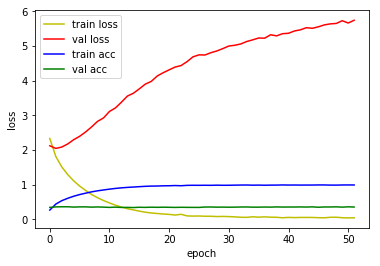

4815/4815 [==============================] - 2s 479us/sample - loss: 2.0960 - acc: 0.3429
Loss: 2.095974131140506 Accuracy: 0.3428868

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0069 - acc: 0.3694
Epoch 00001: val_loss improved from inf to 1.64994, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_025_DO_3_conv_checkpoint/001-1.6499.hdf5
36805/36805 [==============================] - 48s 1ms/sample - loss: 2.0069 - acc: 0.3694 - val_loss: 1.6499 - val_acc: 0.4852
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4076 - acc: 0.5598
Epoch 00002: val_loss improved from 1.64994 to 1.56820, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_025_DO_3_conv_checkpoint/002-1.5682.hdf5
36805/36805 [==============================] - 46s 1ms/sample - loss: 1.4077 - acc: 0.5598 - val_loss: 1.5682 - val_acc: 0.5085
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s -

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0557 - acc: 0.9915
Epoch 00029: val_loss did not improve from 1.52279
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.0556 - acc: 0.9915 - val_loss: 2.4358 - val_acc: 0.5840
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0470 - acc: 0.9937
Epoch 00030: val_loss did not improve from 1.52279
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.0470 - acc: 0.9937 - val_loss: 2.5025 - val_acc: 0.5823
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0515 - acc: 0.9918
Epoch 00031: val_loss did not improve from 1.52279
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.0515 - acc: 0.9918 - val_loss: 2.5235 - val_acc: 0.5802
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0457 - acc: 0.9932
Epoch 00032: val_loss did not improve from 1.52279
36805/36805 [===========

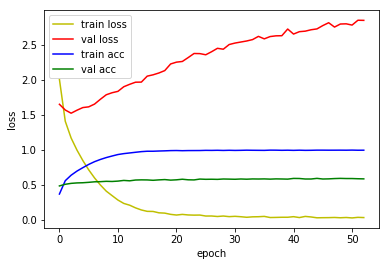

4815/4815 [==============================] - 3s 536us/sample - loss: 1.5866 - acc: 0.4987
Loss: 1.5865661711955243 Accuracy: 0.49865004

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8428 - acc: 0.4080
Epoch 00001: val_loss improved from inf to 1.47112, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_025_DO_4_conv_checkpoint/001-1.4711.hdf5
36805/36805 [==============================] - 49s 1ms/sample - loss: 1.8427 - acc: 0.4081 - val_loss: 1.4711 - val_acc: 0.5425
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3299 - acc: 0.5908
Epoch 00002: val_loss improved from 1.47112 to 1.28120, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_025_DO_4_conv_checkpoint/002-1.2812.hdf5
36805/36805 [==============================] - 48s 1ms/sample - loss: 1.3299 - acc: 0.5908 - val_loss: 1.2812 - val_acc: 0.6182
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0784 - acc: 0.9884
Epoch 00028: val_loss did not improve from 1.19682
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.0784 - acc: 0.9884 - val_loss: 1.4770 - val_acc: 0.6758
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0777 - acc: 0.9884
Epoch 00029: val_loss did not improve from 1.19682
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.0777 - acc: 0.9884 - val_loss: 1.4934 - val_acc: 0.6776
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0683 - acc: 0.9913
Epoch 00030: val_loss did not improve from 1.19682
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.0683 - acc: 0.9913 - val_loss: 1.5051 - val_acc: 0.6748
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0655 - acc: 0.9914
Epoch 00031: val_loss did not improve from 1.19682
36805/36805 [===========

Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0312 - acc: 0.9958
Epoch 00058: val_loss did not improve from 1.19682
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.0312 - acc: 0.9958 - val_loss: 1.8210 - val_acc: 0.6739
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0317 - acc: 0.9957
Epoch 00059: val_loss did not improve from 1.19682
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.0318 - acc: 0.9956 - val_loss: 1.8056 - val_acc: 0.6825

1D_CNN_custom_tanh_DO_025_DO_4_conv Model


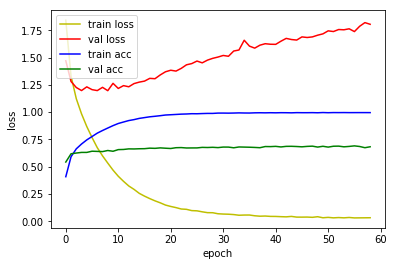

4815/4815 [==============================] - 3s 569us/sample - loss: 1.2426 - acc: 0.6278
Loss: 1.2425976790619293 Accuracy: 0.6278297

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8096 - acc: 0.4205
Epoch 00001: val_loss improved from inf to 1.47831, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_025_DO_5_conv_checkpoint/001-1.4783.hdf5
36805/36805 [==============================] - 51s 1ms/sample - loss: 1.8096 - acc: 0.4205 - val_loss: 1.4783 - val_acc: 0.5344
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3702 - acc: 0.5798
Epoch 00002: val_loss improved from 1.47831 to 1.24806, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_025_DO_5_conv_checkpoint/002-1.2481.hdf5
36805/36805 [==============================] - 49s 1ms/sample - loss: 1.3704 - acc: 0.5798 - val_loss: 1.2481 - val_acc: 0.6296
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s 

36800/36805 [============================>.] - ETA: 0s - loss: 0.1897 - acc: 0.9613
Epoch 00025: val_loss did not improve from 0.85215
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.1897 - acc: 0.9613 - val_loss: 0.9101 - val_acc: 0.7591
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1738 - acc: 0.9660
Epoch 00026: val_loss did not improve from 0.85215
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.1738 - acc: 0.9660 - val_loss: 0.9012 - val_acc: 0.7582
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1634 - acc: 0.9681
Epoch 00027: val_loss did not improve from 0.85215
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.1634 - acc: 0.9681 - val_loss: 0.9123 - val_acc: 0.7626
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1502 - acc: 0.9726
Epoch 00028: val_loss did not improve from 0.85215
36805/36805 [========================

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0403 - acc: 0.9950
Epoch 00055: val_loss did not improve from 0.85215
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.0403 - acc: 0.9950 - val_loss: 1.1322 - val_acc: 0.7661
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0337 - acc: 0.9962
Epoch 00056: val_loss did not improve from 0.85215
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.0337 - acc: 0.9963 - val_loss: 1.1805 - val_acc: 0.7638
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0364 - acc: 0.9952
Epoch 00057: val_loss did not improve from 0.85215
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.0364 - acc: 0.9952 - val_loss: 1.1623 - val_acc: 0.7671
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0332 - acc: 0.9961
Epoch 00058: val_loss did not improve from 0.85215
36805/36805 [===========

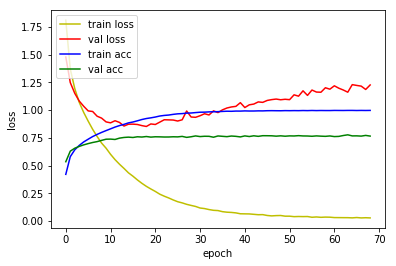

4815/4815 [==============================] - 3s 582us/sample - loss: 0.9325 - acc: 0.7310
Loss: 0.9325461771134151 Accuracy: 0.7310488

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9048 - acc: 0.3830
Epoch 00001: val_loss improved from inf to 1.49195, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_025_DO_6_conv_checkpoint/001-1.4919.hdf5
36805/36805 [==============================] - 53s 1ms/sample - loss: 1.9046 - acc: 0.3830 - val_loss: 1.4919 - val_acc: 0.5353
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4427 - acc: 0.5533
Epoch 00002: val_loss improved from 1.49195 to 1.26672, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_025_DO_6_conv_checkpoint/002-1.2667.hdf5
36805/36805 [==============================] - 50s 1ms/sample - loss: 1.4426 - acc: 0.5533 - val_loss: 1.2667 - val_acc: 0.6164
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s 

36800/36805 [============================>.] - ETA: 0s - loss: 0.4355 - acc: 0.8735
Epoch 00023: val_loss improved from 0.54249 to 0.53749, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_025_DO_6_conv_checkpoint/023-0.5375.hdf5
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.4355 - acc: 0.8735 - val_loss: 0.5375 - val_acc: 0.8465
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4141 - acc: 0.8814
Epoch 00024: val_loss did not improve from 0.53749
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.4142 - acc: 0.8814 - val_loss: 0.5641 - val_acc: 0.8460
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4041 - acc: 0.8827
Epoch 00025: val_loss improved from 0.53749 to 0.52473, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_025_DO_6_conv_checkpoint/025-0.5247.hdf5
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.4041 - acc: 0.8827 - val_loss: 0.5247 -

36800/36805 [============================>.] - ETA: 0s - loss: 0.1937 - acc: 0.9449
Epoch 00049: val_loss improved from 0.45602 to 0.45182, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_025_DO_6_conv_checkpoint/049-0.4518.hdf5
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.1937 - acc: 0.9449 - val_loss: 0.4518 - val_acc: 0.8786
Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1845 - acc: 0.9483
Epoch 00050: val_loss improved from 0.45182 to 0.45094, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_025_DO_6_conv_checkpoint/050-0.4509.hdf5
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.1844 - acc: 0.9483 - val_loss: 0.4509 - val_acc: 0.8786
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1759 - acc: 0.9506
Epoch 00051: val_loss did not improve from 0.45094
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.1759 - acc: 0.9506 - val_loss: 0.4664 -

Epoch 78/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0879 - acc: 0.9767
Epoch 00078: val_loss did not improve from 0.44482
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.0879 - acc: 0.9767 - val_loss: 0.4825 - val_acc: 0.8863
Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0842 - acc: 0.9779
Epoch 00079: val_loss did not improve from 0.44482
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.0842 - acc: 0.9779 - val_loss: 0.4807 - val_acc: 0.8842
Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0845 - acc: 0.9781
Epoch 00080: val_loss did not improve from 0.44482
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.0845 - acc: 0.9781 - val_loss: 0.4906 - val_acc: 0.8863
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0821 - acc: 0.9784
Epoch 00081: val_loss did not improve from 0.44482
36805/36805 [===========

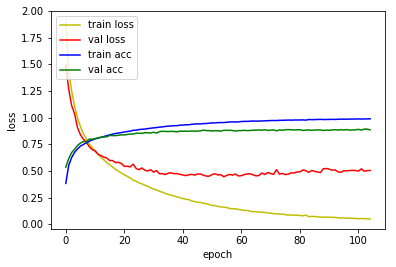

4815/4815 [==============================] - 3s 617us/sample - loss: 0.5230 - acc: 0.8582
Loss: 0.5229580372912366 Accuracy: 0.8581516

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9028 - acc: 0.3868
Epoch 00001: val_loss improved from inf to 1.44088, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_025_DO_7_conv_checkpoint/001-1.4409.hdf5
36805/36805 [==============================] - 55s 1ms/sample - loss: 1.9028 - acc: 0.3868 - val_loss: 1.4409 - val_acc: 0.5558
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4223 - acc: 0.5587
Epoch 00002: val_loss improved from 1.44088 to 1.21072, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_025_DO_7_conv_checkpoint/002-1.2107.hdf5
36805/36805 [==============================] - 51s 1ms/sample - loss: 1.4224 - acc: 0.5586 - val_loss: 1.2107 - val_acc: 0.6324
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s 

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2899 - acc: 0.9165
Epoch 00023: val_loss did not improve from 0.29182
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.2900 - acc: 0.9165 - val_loss: 0.2974 - val_acc: 0.9201
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2761 - acc: 0.9208
Epoch 00024: val_loss improved from 0.29182 to 0.29044, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_025_DO_7_conv_checkpoint/024-0.2904.hdf5
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.2761 - acc: 0.9208 - val_loss: 0.2904 - val_acc: 0.9194
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2682 - acc: 0.9235
Epoch 00025: val_loss did not improve from 0.29044
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.2683 - acc: 0.9234 - val_loss: 0.2908 - val_acc: 0.9187
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - l

Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1334 - acc: 0.9611
Epoch 00050: val_loss did not improve from 0.22370
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.1334 - acc: 0.9611 - val_loss: 0.2268 - val_acc: 0.9366
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1341 - acc: 0.9611
Epoch 00051: val_loss did not improve from 0.22370
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.1341 - acc: 0.9611 - val_loss: 0.2453 - val_acc: 0.9311
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1300 - acc: 0.9607
Epoch 00052: val_loss did not improve from 0.22370
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.1300 - acc: 0.9607 - val_loss: 0.2299 - val_acc: 0.9394
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1263 - acc: 0.9628
Epoch 00053: val_loss did not improve from 0.22370
36805/36805 [===========

Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0730 - acc: 0.9795
Epoch 00079: val_loss did not improve from 0.21665
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.0729 - acc: 0.9795 - val_loss: 0.2311 - val_acc: 0.9394
Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0699 - acc: 0.9806
Epoch 00080: val_loss did not improve from 0.21665
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.0699 - acc: 0.9806 - val_loss: 0.2307 - val_acc: 0.9397
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0709 - acc: 0.9804
Epoch 00081: val_loss did not improve from 0.21665
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.0709 - acc: 0.9804 - val_loss: 0.2279 - val_acc: 0.9406
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0681 - acc: 0.9805
Epoch 00082: val_loss did not improve from 0.21665
36805/36805 [===========

Epoch 109/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0415 - acc: 0.9879
Epoch 00109: val_loss did not improve from 0.21665
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.0415 - acc: 0.9879 - val_loss: 0.2470 - val_acc: 0.9397
Epoch 110/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0391 - acc: 0.9891
Epoch 00110: val_loss did not improve from 0.21665
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.0391 - acc: 0.9891 - val_loss: 0.2566 - val_acc: 0.9413
Epoch 111/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0413 - acc: 0.9891
Epoch 00111: val_loss did not improve from 0.21665
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.0413 - acc: 0.9891 - val_loss: 0.2299 - val_acc: 0.9404
Epoch 112/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0394 - acc: 0.9896
Epoch 00112: val_loss did not improve from 0.21665
36805/36805 [=======

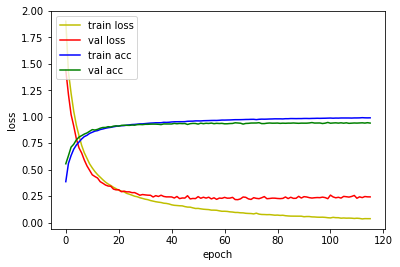

4815/4815 [==============================] - 3s 646us/sample - loss: 0.2609 - acc: 0.9215
Loss: 0.26094469949835186 Accuracy: 0.9214953

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8508 - acc: 0.4058
Epoch 00001: val_loss improved from inf to 1.38881, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_025_DO_8_conv_checkpoint/001-1.3888.hdf5
36805/36805 [==============================] - 56s 2ms/sample - loss: 1.8506 - acc: 0.4058 - val_loss: 1.3888 - val_acc: 0.5921
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2727 - acc: 0.6158
Epoch 00002: val_loss improved from 1.38881 to 1.00392, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_025_DO_8_conv_checkpoint/002-1.0039.hdf5
36805/36805 [==============================] - 52s 1ms/sample - loss: 1.2726 - acc: 0.6158 - val_loss: 1.0039 - val_acc: 0.7098
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1688 - acc: 0.9518
Epoch 00024: val_loss did not improve from 0.17340
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.1688 - acc: 0.9518 - val_loss: 0.1750 - val_acc: 0.9490
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1630 - acc: 0.9524
Epoch 00025: val_loss improved from 0.17340 to 0.16587, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_025_DO_8_conv_checkpoint/025-0.1659.hdf5
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.1631 - acc: 0.9524 - val_loss: 0.1659 - val_acc: 0.9525
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1593 - acc: 0.9527
Epoch 00026: val_loss improved from 0.16587 to 0.16002, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_025_DO_8_conv_checkpoint/026-0.1600.hdf5
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.1593 - acc: 0.9527 - val_l

36800/36805 [============================>.] - ETA: 0s - loss: 0.0713 - acc: 0.9788
Epoch 00050: val_loss did not improve from 0.14160
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.0713 - acc: 0.9788 - val_loss: 0.1532 - val_acc: 0.9569
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0685 - acc: 0.9806
Epoch 00051: val_loss did not improve from 0.14160
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.0685 - acc: 0.9806 - val_loss: 0.1482 - val_acc: 0.9548
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0659 - acc: 0.9809
Epoch 00052: val_loss did not improve from 0.14160
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.0659 - acc: 0.9809 - val_loss: 0.1541 - val_acc: 0.9548
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0664 - acc: 0.9806
Epoch 00053: val_loss did not improve from 0.14160
36805/36805 [========================

Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0282 - acc: 0.9928
Epoch 00079: val_loss did not improve from 0.13864
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.0282 - acc: 0.9928 - val_loss: 0.1493 - val_acc: 0.9597
Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0254 - acc: 0.9935
Epoch 00080: val_loss did not improve from 0.13864
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.0254 - acc: 0.9935 - val_loss: 0.1529 - val_acc: 0.9602
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0258 - acc: 0.9932
Epoch 00081: val_loss did not improve from 0.13864
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.0258 - acc: 0.9932 - val_loss: 0.1563 - val_acc: 0.9604
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0256 - acc: 0.9940
Epoch 00082: val_loss did not improve from 0.13864
36805/36805 [===========

Epoch 109/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0123 - acc: 0.9974
Epoch 00109: val_loss did not improve from 0.13864
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.0123 - acc: 0.9974 - val_loss: 0.1624 - val_acc: 0.9616
Epoch 110/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0135 - acc: 0.9970
Epoch 00110: val_loss did not improve from 0.13864
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.0135 - acc: 0.9970 - val_loss: 0.1816 - val_acc: 0.9576
Epoch 111/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0156 - acc: 0.9963
Epoch 00111: val_loss did not improve from 0.13864
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.0156 - acc: 0.9963 - val_loss: 0.1634 - val_acc: 0.9613
Epoch 112/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0121 - acc: 0.9973
Epoch 00112: val_loss did not improve from 0.13864
36805/36805 [=======

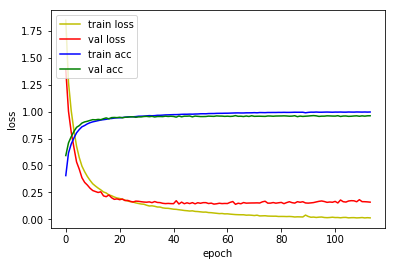

4815/4815 [==============================] - 3s 672us/sample - loss: 0.1818 - acc: 0.9441
Loss: 0.181804375336549 Accuracy: 0.9441329

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5643 - acc: 0.5084
Epoch 00001: val_loss improved from inf to 0.96322, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_025_DO_9_conv_checkpoint/001-0.9632.hdf5
36805/36805 [==============================] - 58s 2ms/sample - loss: 1.5642 - acc: 0.5084 - val_loss: 0.9632 - val_acc: 0.7067
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8646 - acc: 0.7398
Epoch 00002: val_loss improved from 0.96322 to 0.62579, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_025_DO_9_conv_checkpoint/002-0.6258.hdf5
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.8646 - acc: 0.7398 - val_loss: 0.6258 - val_acc: 0.8157
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s -

36800/36805 [============================>.] - ETA: 0s - loss: 0.0645 - acc: 0.9820
Epoch 00024: val_loss improved from 0.13835 to 0.13068, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_025_DO_9_conv_checkpoint/024-0.1307.hdf5
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.0645 - acc: 0.9820 - val_loss: 0.1307 - val_acc: 0.9630
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0605 - acc: 0.9844
Epoch 00025: val_loss did not improve from 0.13068
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.0605 - acc: 0.9844 - val_loss: 0.1386 - val_acc: 0.9585
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0565 - acc: 0.9837
Epoch 00026: val_loss did not improve from 0.13068
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.0565 - acc: 0.9837 - val_loss: 0.1352 - val_acc: 0.9611
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0515 -

Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0121 - acc: 0.9975
Epoch 00053: val_loss did not improve from 0.12734
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.0121 - acc: 0.9975 - val_loss: 0.1520 - val_acc: 0.9644
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0125 - acc: 0.9972
Epoch 00054: val_loss did not improve from 0.12734
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.0125 - acc: 0.9972 - val_loss: 0.1536 - val_acc: 0.9637
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0115 - acc: 0.9973
Epoch 00055: val_loss did not improve from 0.12734
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.0115 - acc: 0.9973 - val_loss: 0.1576 - val_acc: 0.9620
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0097 - acc: 0.9981
Epoch 00056: val_loss did not improve from 0.12734
36805/36805 [===========

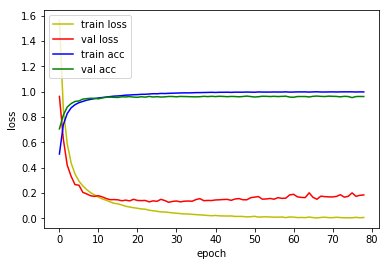

4815/4815 [==============================] - 3s 677us/sample - loss: 0.1797 - acc: 0.9472
Loss: 0.17967637111959922 Accuracy: 0.94724816



In [10]:
for i in range(1, 10):
    base = '1D_CNN_custom_tanh_DO_025_DO'
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_DO(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_tanh_DO_025_DO'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(1, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_tanh_DO_025_DO_1_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
activation_45 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 1024000)           0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 1024000)           0         
_________________________________________________________________
dense_9 (Dense)              (None, 16)                16384016  
Total params: 16,384,400
Trainable params: 16,384,400
Non-trainable params: 0
_________________________________________________________________
4815/4815 [==============================] - 2s 352us/sample - loss: 2.7266 - acc: 0.10

4815/4815 [==============================] - 3s 667us/sample - loss: 0.9325 - acc: 0.7310
Loss: 0.9325461771134151 Accuracy: 0.7310488

1D_CNN_custom_tanh_DO_025_DO_6_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_60 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
activation_60 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_61 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
activation_61 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_46 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_62 (Conv1D)           (

4815/4815 [==============================] - 3s 716us/sample - loss: 0.1818 - acc: 0.9441
Loss: 0.181804375336549 Accuracy: 0.9441329

1D_CNN_custom_tanh_DO_025_DO_9_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_81 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
activation_81 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_82 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
activation_82 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_64 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_83 (Conv1D)           (N

In [12]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
# base = '1D_CNN_custom_tanh_DO'

with open(path.join(log_dir, base+'_last'), 'w') as log_file:
    for i in range(1, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + '000_last.hdf5'

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_tanh_DO_025_DO_1_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
activation_45 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 1024000)           0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 1024000)           0         
_________________________________________________________________
dense_9 (Dense)              (None, 16)                16384016  
Total params: 16,384,400
Trainable params: 16,384,400
Non-trainable params: 0
_________________________________________________________________
4815/4815 [==============================] - 2s 442us/sample - loss: 9.3682 - acc: 0.09

4815/4815 [==============================] - 4s 737us/sample - loss: 1.3502 - acc: 0.7288
Loss: 1.3501875538939876 Accuracy: 0.7287643

1D_CNN_custom_tanh_DO_025_DO_6_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_60 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
activation_60 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_61 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
activation_61 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_46 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_62 (Conv1D)           (

4815/4815 [==============================] - 4s 778us/sample - loss: 0.2043 - acc: 0.9475
Loss: 0.20429745706597097 Accuracy: 0.9474559

1D_CNN_custom_tanh_DO_025_DO_9_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_81 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
activation_81 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_82 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
activation_82 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_64 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_83 (Conv1D)           